In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

###################################
# First policy:
#           DOWN = 0
#           RIGHT = 1
#           UP = 2
#           LEFT = 3
# Second Policy
#           DownRight = 0
#           UpRight = 1
#           UpLeft = 2
#           DownLeft = 3
###################################
POLICIES = [[(1, 0), (0, 1), (-1, 0), (0, -1)], 
            [(1, 1), (-1, 1), (-1, -1), (1, -1)]]

OBSTACLE = 1
OBSTACLE_REWARD = -10
END_REWARD = 100
DUMMY = 0.1
E_POWER_SCALING = 0.0001

In [2]:
def sample(dist):
    wheel = np.cumsum(dist)
    return np.argwhere(np.random.random() < wheel)[0][0]

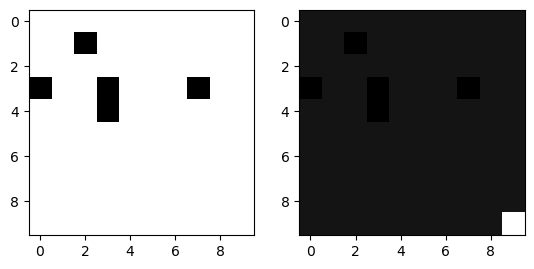

In [3]:
class Grid:
    def __init__(self, size, density, seed = 1234):
        self.size = size
        self.GRID = np.zeros((size, size))

        self.START = (0,0)
        self.END = (size-1, size-1)

        self.density = density
        self.seed = seed

    def check_collision(self, state):
        if state[0] < 0 or state[0] >= self.size or state[1] < 0  or state[1] >= self.size:
            return False
        elif self.GRID[state[0]][state[1]] == OBSTACLE:
            return False
        return True
    
    def generate_obstacles(self):

        np.random.seed(self.seed)
        RANDOM_MATRIX = np.random.random((self.size, self.size))

        for i in range(self.size):
            for j in range(self.size):
                if (i,j) == self.START or (i,j) == self.END:
                    continue
                if RANDOM_MATRIX[i][j] <= self.density:
                    self.GRID[i][j] = OBSTACLE

    
    def reward(self, state):
        if state == self.END:
            return END_REWARD
        else:
            if self.check_collision(state):
                #return - np.sqrt(((state[0] - self.END[0])**2 + (state[1] - self.END[1])**2)/ (self.END[0]**2 + self.END[1]**2)) * 5
                return -1
                #return 0
            else:
                return OBSTACLE_REWARD
            
    def display(self):
        plt.imshow(1-self.GRID, cmap="gray")
            
# REWARD DISPLAY
temp_env = Grid(10, 0.1, 12345)
temp_env.generate_obstacles()
reward_grid = np.array([[temp_env.reward((i,j)) for j in range(temp_env.size)] for i in range(temp_env.size)])

plt.subplot(1,2,1)
temp_env.display()

plt.subplot(1,2,2)
plt.imshow(reward_grid / 5, cmap="gray")

In [ ]:
class Policy:
    def __init__(self, env, gamma, ACTIONS):
        self.env = env
        self.num_states = self.env.size * self.env.size
        self.gamma = gamma
        self.ACTIONS = ACTIONS
        self.num_actions = len(self.ACTIONS)
        
        # q_pi and v_pi
        self.q_pi = np.ones((self.num_states, self.num_actions)).astype(np.float32)
        self.v_pi = np.full((self.num_states), DUMMY).astype(np.float32)
        self.q_pi_prob = self.q_pi / np.sum(self.q_pi, axis = 1).reshape((-1,1))


    def update_probs(self):
        # self.q_pi_prob = (self.q_pi - np.min(self.q_pi)) / (np.max(self.q_pi, axis = 1) - np.min(self.q_pi, axis = 1))
        self.q_pi_prob = np.exp(E_POWER_SCALING * self.q_pi) / np.sum(np.exp(E_POWER_SCALING * self.q_pi), axis = 1).reshape(-1,1)


class Agent:
    
    def __init__(self, env, POLICIES, gamma = 0.8, exploitation_threshold = 0.3):
        self.env = env
        self.POLICIES = [Policy(self.env, gamma, p) for p in POLICIES]
        self.gamma = gamma
        self.exploitation_threshold = exploitation_threshold

    def run_episode(self, state):

        #print(state, end = "===>")
        # end condition of recursion
        # if self.env.GRID[state[0]][state[1]] == OBSTACLE or state == self.env.END:
        #     return self.env.reward(state)
        
        # default run
        
        #PICK POLICY
        state_index = state[0] * self.env.size + state[1]
        state_values = [p.v_pi[state_index] for p in self.POLICIES]
        state_values = np.array(state_values)
        # state_values = (state_values - np.min(state_values)) / (np.max(state_values) - np.min(state_values + 1e-7))
        state_values = np.exp(E_POWER_SCALING * state_values) / np.sum(np.exp(E_POWER_SCALING * state_values))

        if np.random.random() < self.exploitation_threshold:
            policy_index = np.argmax(state_values)
            policy = self.POLICIES[policy_index]
            action_index = np.argmax(policy.q_pi_prob[state_index])
        else:
            policy_index = sample(state_values)
            policy = self.POLICIES[policy_index]
            action_index = sample(policy.q_pi_prob[state_index])

        


        # perform action
        next_state = (state[0] + policy.ACTIONS[action_index][0], state[1] + policy.ACTIONS[action_index][1])
        next_state_index = next_state[0] * self.env.size + next_state[1]
        #print(next_state)
        next_reward = self.env.reward(next_state)

        if next_reward == OBSTACLE_REWARD or next_reward == END_REWARD:
            #print("here")
            G_t = next_reward
        else:
            G_t = (next_reward + self.gamma * self.run_episode(next_state))

        #print(policy.q_pi[state_index], state)
        policy.v_pi[state_index] = policy.q_pi_prob[state_index][action_index] * G_t
        policy.q_pi[state_index][action_index] = G_t
        #print(policy.q_pi[state_index], state)

        return G_t 
    
    def infer(self, state):

        print(state, end = "===>")

        # end condition of recursion
        if self.env.GRID[state[0]][state[1]] == OBSTACLE or state == self.env.END:
            return self.env.reward(state)
        
        # default run
        
        #PICK POLICY
        state_index = state[0] * self.env.size + state[1]
        state_values = [p.v_pi[state_index] for p in self.POLICIES]
        state_values = np.array(state_values) / np.sum(state_values)

        policy_index = np.argmax(state_values)
        policy = self.POLICIES[policy_index]

        #picking action
        action_index = np.argmax(policy.q_pi_prob[state_index])

        # perform action
        next_state = (state[0] + policy.ACTIONS[action_index][0], state[1] + policy.ACTIONS[action_index][1])
        next_state_index = next_state[0] * self.env.size + next_state[1]
        print(next_state)
        G_t = self.env.reward(next_state) + self.gamma * self.infer(next_state)

        # policy.v_pi[state_index] = G_t
        # policy.q_pi[state_index][action_index] = G_t

        return G_t 

In [5]:
dummy_agent = Agent(temp_env, POLICIES)

In [8]:
for _ in tqdm(range(10000000)):
    #print("_______EPISODE________")
    run_reward = dummy_agent.run_episode(temp_env.START)
    dummy_agent.POLICIES[0].update_probs()
    dummy_agent.POLICIES[1].update_probs()
    if dummy_agent.exploitation_threshold < 0.9:
        dummy_agent.exploitation_threshold += 0.00001
    # print("run-reward : ", run_reward)



  0%|          | 9574/10000000 [00:03<53:22, 3119.85it/s]  


RecursionError: maximum recursion depth exceeded

In [ ]:
dummy_agent.infer(temp_env.START)

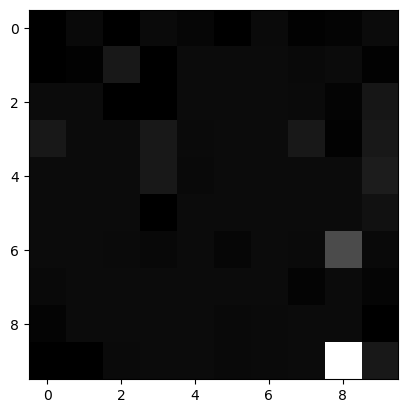

In [7]:
plt.imshow(dummy_agent.POLICIES[0].v_pi.reshape((10,10)), cmap = "gray")

In [ ]:
plt.imshow(dummy_agent.POLICIES[1].v_pi.reshape((10,10)), cmap = "gray")

In [ ]:
dummy_agent.POLICIES[1].q_pi_prob

In [ ]:
dist = np.array([0.5, 0.2, 0.2, 0.1])

In [ ]:
samples = [sample(dist) for i in range(1000)]

In [ ]:
np.unique(samples, return_counts=True)

In [ ]:
class Dumy:
    def __init__(self):
        self.x = 10

class Big:

    def __init__(self):
        self.temp = [Dumy(), Dumy()]

    def boom(self):
        self.temp[0].x = 234

        doom = self.temp[1]

        doom.x = 13243

In [ ]:
obj = Big()

In [ ]:
obj.temp[0].x, obj.temp[1].x

In [ ]:
obj.boom()